In [17]:
import sys
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf
from pathlib import Path
import pandas as pd
import numpy as np
import random
import datetime
import tensorflow.keras as keras
from tensorflow.keras import layers, Input
from tensorflow.keras.optimizers import Adam
import tensorflow.keras.backend as K
from tensorflow.keras.callbacks import Callback
import matplotlib.pyplot as plt
from PIL import Image
from PIL import UnidentifiedImageError
from sklearn.metrics import mean_squared_error

def initialise_session():
    K.clear_session()
    physical_devices = tf.config.list_physical_devices('GPU')
    num_physical_devices = len(physical_devices)
    print("GPUs Available: ", num_physical_devices)
    if num_physical_devices > 0:
        tf.config.set_visible_devices(physical_devices[0], 'GPU')
        tf.config.experimental.set_memory_growth(physical_devices[0], True)
        
def find_directory():
    try:
        # Check if running in a Jupyter notebook
        shell = get_ipython().__class__.__name__
        if shell == 'ZMQInteractiveShell':
            # Running in a Jupyter notebook
            directory = os.getcwd()
        else:
            # Running in a standalone Python script
            directory = Path(__file__).parent
    except NameError:
        # Running in a standalone Python script
        directory = Path(__file__).parent
    return directory
            
def build_train_image_paths(path_to_data):
    def absolute_file_paths(directory):
        for dirpath, _, filenames in os.walk(directory):
            for filename in sorted(filenames, key=lambda x: int(x.split('.')[0]) if x.split('.')[0].isdigit() else float('inf')):
                if not filename.split('.')[0].isdigit():
                    continue
                yield os.path.abspath(os.path.join(dirpath, filename))
    train_image_paths = []
    for file_path in absolute_file_paths(f"{path_to_data}/training_data/combined"):
        train_image_paths.append(file_path)
    path_indexes_to_remove = []
    for i, image_path in enumerate(train_image_paths):
        try:
            Image.open(image_path)
        except UnidentifiedImageError:
            path_indexes_to_remove.append(i)
    for index in sorted(path_indexes_to_remove, reverse=True):
        train_image_paths.pop(index)
        
    train_image_paths_and_labels = pd.DataFrame()
    train_image_paths_and_labels['image_path'] = train_image_paths

    training_norm = pd.read_csv(f"{path_to_data}/training_norm.csv")
    for image_path in train_image_paths:
        image_id = int((image_path.split('.')[0]).split('/')[-1])
        angle = training_norm.loc[training_norm['image_id'] == image_id,
                                'angle'].iloc[0]
        speed = int((training_norm.loc[training_norm['image_id'] == image_id,
                                    'speed'].iloc)[0])
        train_image_paths_and_labels.loc[train_image_paths_and_labels['image_path'] == image_path, 'angle'] = angle
        train_image_paths_and_labels.loc[train_image_paths_and_labels['image_path'] == image_path, 'speed'] = speed
    return train_image_paths_and_labels

def build_test_image_paths(path_to_data):
    image_ids = np.arange(1, 1021)
    test_image_paths = pd.DataFrame({'image_path': []})
    for image_id in image_ids:
        full_path = str(f"{path_to_data}/test_data/test_data/{str(image_id)}.png")
        test_image_paths.loc[len(test_image_paths)] = full_path
    return test_image_paths
        
def build_image_paths(directory):
    path_to_data = f"{directory}/machine-learning-in-science-ii-2023"
    train_image_paths_and_labels = build_train_image_paths(path_to_data)
    test_image_paths = build_test_image_paths(path_to_data)
    return train_image_paths_and_labels, test_image_paths

def load_files_and_paths(directory):
    if 'google.colab' in sys.modules:
        from google.colab import drive
        drive.mount('/content/drive')
        path_to_data = Path("/content/drive/MyDrive/machine-learning-in-science-ii-2023")
        train_image_paths = pd.read_csv(str(path_to_data/'training_norm_paths_googledrive.csv'))
        test_image_paths = pd.read_csv(str(path_to_data/'test_image_paths_googledrive.csv'))
    else:
        train_image_paths, test_image_paths = build_image_paths(directory)
    return train_image_paths, test_image_paths
    
def load_training_images_and_labels(image_path, speed_label, angle_label, image_shape):
    # Define a function that maps each row to an image and a pair of labels
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_shape)
    speed_label = tf.cast(speed_label, tf.int32)
    angle_label = tf.cast(angle_label, tf.float32)
    return image, (speed_label, angle_label)

def augment(image_label, seed):
    image, label = image_label
    new_seed = tf.random.experimental.stateless_split(seed, num=1)[0, :]
    image = tf.image.stateless_random_brightness(
        image, max_delta=0.5, seed=new_seed)
    return image, label

def build_training_validation_and_evaluation_sets(train_image_paths, image_shape, batch_size, train_val_split):
    dataset = tf.data.Dataset.from_tensor_slices((train_image_paths['image_path'],
                                                  train_image_paths['speed'],
                                                  train_image_paths['angle']))
    dataset = dataset.map(lambda x,y,z: load_training_images_and_labels(x,y,z, image_shape)).batch(batch_size)
    num_batches = dataset.cardinality().numpy()
    dataset = dataset.shuffle(buffer_size=num_batches*batch_size)

    train_batches = int(num_batches * train_val_split[0])
    val_batches = int(num_batches * train_val_split[1])
    eval_batches = num_batches - train_batches - val_batches

    train_set = dataset.take(train_batches)
    val_set = dataset.skip(train_batches).take(val_batches)
    eval_set = dataset.skip(train_batches + val_batches)

    AUTOTUNE = tf.data.AUTOTUNE
    counter = tf.data.Dataset.counter()
    train_set = tf.data.Dataset.zip((train_set, (counter, counter)))
    train_set = train_set.map(augment, num_parallel_calls=AUTOTUNE)
    
    train_set = train_set.cache().prefetch(buffer_size=AUTOTUNE)
    val_set = val_set.cache().prefetch(buffer_size=AUTOTUNE)
    eval_set = eval_set.cache().prefetch(buffer_size=AUTOTUNE)
    
    return train_set, val_set, eval_set


class CNNs(keras.Model):
    def __init__(self, image_shape, name='CNNs'):
        super(CNNs, self).__init__(name=name)
        self.image_shape = image_shape
        
        self.CNN_speed = keras.Sequential([
            Input(shape=image_shape+(3,)),
            layers.Conv2D(32, 3,
                          padding="valid",
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.1)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.1)
                          ),
            layers.Dropout(0.5),
            layers.MaxPooling2D(),
            layers.Conv2D(128, 3,
                          activation="relu",
                          kernel_regularizer=keras.regularizers.l2(0.1)
                          ),
            layers.Dropout(0.5),
            layers.Flatten(),
            layers.Dense(64,
                         activation="relu",
                         kernel_regularizer=keras.regularizers.l2(0.2)
                         ),
            layers.Dropout(0.5),
            layers.Dense(10)
        ], name='CNN_speed')
        
        self.CNN_angle = keras.Sequential([
            Input(shape=image_shape+(3,)),
            layers.Conv2D(32, 3, padding="valid", activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(64, 3, activation="relu"),
            layers.MaxPooling2D(),
            layers.Conv2D(128, 3, activation="relu"),
            layers.Flatten(),
            layers.Dense(64, activation="relu"),
            layers.Dense(10)
        ], name='CNN_angle')

        self.speed_output = keras.layers.Dense(1, activation=None, name='speed')
        self.angle_output = keras.layers.Dense(1, activation='linear', name='angle')
    
    @tf.function
    def call(self, inputs):
        x = self.CNN_speed(inputs)
        y = self.CNN_angle(inputs)
        
        speed_output = self.speed_output(x)
        angle_output = self.angle_output(y)
        return [speed_output, angle_output]


def build_model(image_shape):
    inputs = keras.layers.Input(shape=image_shape+(3,))
    [speed_output, angle_output] = CNNs(image_shape)(inputs)

    # Name outputs
    speed_output = layers.Lambda(lambda x: x, name='speed')(speed_output)
    angle_output = layers.Lambda(lambda x: x, name='angle')(angle_output)

    model = keras.models.Model(inputs=inputs, outputs=[speed_output, angle_output])
    model.summary()
    return model

def f1_score(y_true, y_pred):
    """
    Function to calculate the F1 score.
    """
    def recall(y_true, y_pred):
        """
        Recall metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = true_positives / (possible_positives + K.epsilon())
        return recall

    def precision(y_true, y_pred):
        """
        Precision metric.
        """
        true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = true_positives / (predicted_positives + K.epsilon())
        return precision

    precision = precision(y_true, y_pred)
    recall = recall(y_true, y_pred)
    f1_score = 2 * ((precision * recall) / (precision + recall + K.epsilon()))
    return f1_score

       
class CombinedMSECallback(Callback):
    def __init__(self, eval_set):
        super().__init__()
        self.eval_set = eval_set
        self.combined_mse_history = []
        # Get the true labels for the evaluation set
        y_true_speed = np.concatenate([y[0].numpy() for x, y in eval_set], axis=0)
        y_true_angle = np.concatenate([y[1].numpy() for x, y in eval_set], axis=0)
        self.y_true = np.stack((y_true_speed, y_true_angle), axis=-1)
        self.boundary = lambda x: 1 if x > 0.5 else 0
        angles = [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5,
                  0.5625, 0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
        self.closest_angle_round = lambda x: angles[min(range(len(angles)),
                                                key = lambda i: abs(angles[i]-x))]

    def on_test_end(self, logs=None):
        # Assuming `eval_set` is the evaluation dataset returned by your function
        # and `model` is your trained model

        # Run model.predict on the evaluation set to get the predicted labels
        y_pred = model.predict(self.eval_set, verbose=0)
        y_pred = np.hstack(y_pred)
        y_pred[:, 0] = np.vectorize(self.boundary)(y_pred[:, 0])
        y_pred[:, 1] = np.vectorize(self.closest_angle_round)(y_pred[:, 1])

        # Calculate the MSE for each output separately
        mse_speed = mean_squared_error(self.y_true[:, 0], y_pred[:, 0])
        mse_angle = mean_squared_error(self.y_true[:, 1], y_pred[:, 1])

        # Combine the MSE values into a single metric
        combined_mse = (mse_speed + mse_angle) / 2
        self.combined_mse_history.append(combined_mse)
        print(f'\nEvaluation MSE: {combined_mse}')

def create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps):
    decay_rate = (final_learning_rate / initial_learning_rate) ** (1. / total_decay_steps)
    learning_rate_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate,
        decay_steps=total_decay_steps,
        decay_rate=decay_rate,
        staircase=True)
    return learning_rate_schedule
        
def train_model(model, train_set, val_set, epochs, logging, initial_learning_rate, final_learning_rate, total_decay_steps):
    learning_rate_schedule = create_learning_rate_schedule(initial_learning_rate, final_learning_rate, total_decay_steps)
    model.compile(
        optimizer = Adam(learning_rate=learning_rate_schedule),
        loss={
            'speed': keras.losses.BinaryCrossentropy(from_logits=True),
            'angle': keras.losses.MeanSquaredError()
        },
        loss_weights={
            'speed': 1,
            'angle': 1
        }
    )

    early_stopping_callback = keras.callbacks.EarlyStopping(monitor='val_loss',
                                                            start_from_epoch=1000,
                                                            restore_best_weights=True)
    combined_mse_callback = CombinedMSECallback(eval_set)

    if logging:
        log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
        tf.profiler.experimental.start(log_dir)
    
    history = model.fit(train_set,
                        epochs=epochs,
                        validation_data=val_set,
                        callbacks=[early_stopping_callback, combined_mse_callback])
    
    if logging:
        tf.profiler.experimental.stop()
        # to view log execute: "tensorboard --logdir=logs/fit/"
        
    combined_mse_history = combined_mse_callback.combined_mse_history
    return model, history, combined_mse_history

def evaluate_model(history, combined_mse_history, epochs, epoch_offset):
    lowest_evaluation_loss = str(round(min(combined_mse_history), 5))
    print(f"Lowest evaluation loss: {lowest_evaluation_loss}")
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(epochs)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.plot(epochs_range[epoch_offset:], combined_mse_history[epoch_offset:], color='g', label='Evaluation MSE')
    ax1.legend(loc='upper right')
    ax1.set_title('Evaluation Loss')
    ax2.plot(epochs_range[epoch_offset:], loss[epoch_offset:], label='Training Loss')
    ax2.plot(epochs_range[epoch_offset:], val_loss[epoch_offset:], label='Validation Loss')
    ax2.legend(loc='upper right')
    ax2.set_title('Training and Validation Loss')
    plt.show()
    return lowest_evaluation_loss
    
def load_testing_images(image_path, image_shape):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, image_shape)
    image = tf.expand_dims(image, axis=0)
    return image

def build_test_set(test_image_paths, image_shape):
    test_set = tf.data.Dataset.from_tensor_slices(test_image_paths['image_path'])
    test_set = test_set.map(lambda x: load_testing_images(x, image_shape))
    return test_set

def threshold_predictions(predictions_df):
    boundary = lambda x: 1 if x > 0.5 else 0
    predictions_df['speed'] = predictions_df['speed'].apply(boundary)

    angles = [0.0, 0.0625, 0.125, 0.1875, 0.25, 0.3125, 0.375, 0.4375, 0.5, 0.5625,
            0.625, 0.6875, 0.75, 0.8125, 0.875, 0.9375, 1.0]
    closest_angle_round = lambda x: angles[min(range(len(angles)),
                                            key = lambda i: abs(angles[i]-x))]
    predictions_df['angle'] = predictions_df['angle'].apply(closest_angle_round)
    return predictions_df

def make_predictions(model, test_set):
    predictions = model.predict(test_set)

    speed_predictions = predictions[0]
    angle_predictions = predictions[1]

    predictions_df = pd.DataFrame()
    predictions_df['image_id'] = np.arange(1, 1021)
    predictions_df['angle'] = angle_predictions
    predictions_df['speed'] = speed_predictions

    predictions_df = threshold_predictions(predictions_df)
    return predictions_df
    
def create_submission(predictions_df, name, directory):
    submission_directory = f"{directory}/submissions"
    if not os.path.exists(submission_directory):
        os.makedirs(submission_directory)
    predictions_df.to_csv(f"{submission_directory}/submission_speedval-{name}.csv", index=False)
    
def save_tf_model(model, name, path_to_models):
    tf_model_save_path = f"{path_to_models}/tf/{name}/"
    tf.saved_model.save(model, tf_model_save_path)
    return tf_model_save_path

def save_tflite_model(model, name, path_to_models, tf_model_save_path):
    # Convert the model to tflite
    tflite_model = tf.lite.TFLiteConverter.from_saved_model(tf_model_save_path).convert()
    tflite_save_path = f"{path_to_models}/tflite"
    if not os.path.exists(tflite_save_path):
        os.makedirs(tflite_save_path)
    tflite_model_save_path = f"{tflite_save_path}/{name}"
    os.mkdir(tflite_model_save_path)
    with open(f"{tflite_model_save_path}/model.tflite", 'wb') as f:
        f.write(tflite_model)
        
def test_model(model, test_image_paths, image_shape, name, directory):
    test_decision = None
    print('Make submission? (y/n)')
    while test_decision != 'y' and test_decision != 'n':
        test_decision = input('>>> ')
        if test_decision == 'y':
            test_set = build_test_set(test_image_paths, image_shape)
            predictions_df = make_predictions(model, test_set)
            create_submission(predictions_df, name, directory)
        elif test_decision == 'n':
            break
        else:
            print("Invalid. Enter 'y' or 'n'")

def save_model(model, name, directory):
    save_decision = None
    print('Save model? (y/n)')
    while save_decision != 'y' and save_decision != 'n':
        save_decision = input('>>> ')
        if save_decision == 'y':
            path_to_models = f"{directory}/models"
            if not os.path.exists(path_to_models):
                os.makedirs(path_to_models)
            tf_model_save_path = save_tf_model(model, name, path_to_models)
            save_tflite_model(model, name, path_to_models, tf_model_save_path)
        elif save_decision == 'n':
            break
        else:
            print("Invalid. Enter 'y' or 'n'")

In [18]:
# --- HYPERPARAMETERS ---
batch_size = 40
epochs = 100
train_val_split = [0.7, 0.2]
image_shape = (32, 32) # (32, 32) works well
logging = False # log using tensorboard
initial_learning_rate = 0.001
final_learning_rate = 0.00001
total_decay_steps = 100
# -----------------------

# --- TRAIN ---
initialise_session()
directory = find_directory()
train_image_paths, test_image_paths = load_files_and_paths(directory)
train_set, val_set, eval_set = build_training_validation_and_evaluation_sets(train_image_paths,
                                                                   image_shape,
                                                                   batch_size,
                                                                   train_val_split)
model = build_model(image_shape)
model, history, combined_mse_history = train_model(model, train_set, val_set, epochs, logging, initial_learning_rate, final_learning_rate, total_decay_steps)

GPUs Available:  1
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 CNNs (CNNs)                    [(None, 1),          450090      ['input_1[0][0]']                
                                 (None, 1)]                                                       
                                                                                                  
 speed (Lambda)                 (None, 1)            0           ['CNNs[0][0]']                   
                                                                                                  
 angle (Lambda)                 (None, 1)            0           ['CNNs[0][

Lowest evaluation loss: 0.02583


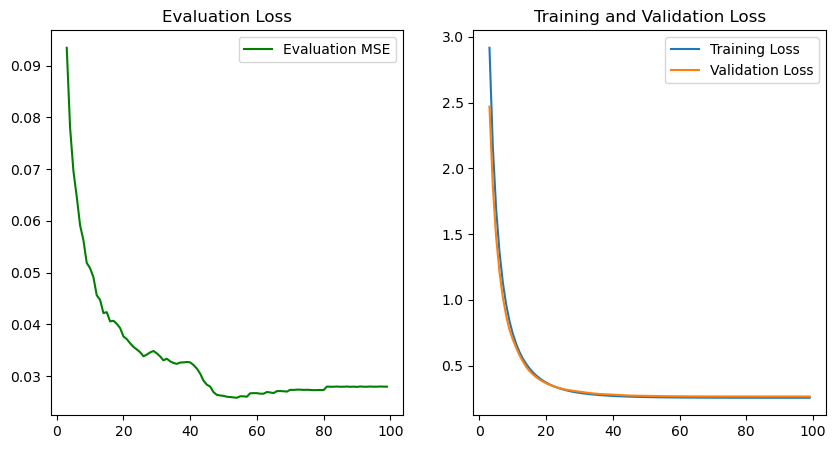

In [21]:
# --- ANALYSE ---
name = evaluate_model(history, combined_mse_history, epochs, epoch_offset=3)

In [32]:
# --- MAKE SUBMISSION ---
test_model(model, test_image_paths, image_shape, name, directory)

Make submission? (y/n)
Invalid. Enter 'y' or 'n'
1020/1020 [==============================] - 5s 4ms/step


In [33]:
# --- SAVE MODEL ---
save_model(model, name, directory)

Save model? (y/n)
INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc66004b790>, 140492221976288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc66004b790>, 140492221976288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d025c730>, 140489750467328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d025c730>, 140489750467328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d0266610>, 140489750365808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d0266610>, 140489750365808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d024ebb0>, 140489750365728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d024ebb0>, 140489750365728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc66004b790>, 140492221976288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc66004b790>, 140492221976288), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d025c730>, 140489750467328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d025c730>, 140489750467328), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d0266610>, 140489750365808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(10, 1), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d0266610>, 140489750365808), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d024ebb0>, 140489750365728), {}).


INFO:tensorflow:Unsupported signature for serialization: ((TensorSpec(shape=(1,), dtype=tf.float32, name='gradient'), <tensorflow.python.framework.func_graph.UnknownArgument object at 0x7fc6d024ebb0>, 140489750365728), {}).


INFO:tensorflow:Assets written to: /home/harry/ML_GPU/DeepDreams/models/tf/0.02993/assets


INFO:tensorflow:Assets written to: /home/harry/ML_GPU/DeepDreams/models/tf/0.02993/assets
